# Libraries

In [74]:
import numpy as np
import pandas as pd

# metrics

In [75]:
def confusion_matrix(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def accuracy_score(y_true, y_pred):
    return np.mean(np.asarray(y_true) == np.asarray(y_pred))

def precision_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp = cm[1,1], cm[0,1]
    return tp / (tp + fp) if (tp + fp) else 0

def recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fn = cm[1,1], cm[1,0]
    return tp / (tp + fn) if (tp + fn) else 0

def f1_score(y_true, y_pred):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) else 0

def silhouette_score(X, labels):
    X = np.asarray(X)
    labels = np.asarray(labels)
    n = X.shape[0]
    uniq = np.unique(labels)
    
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            D[i, j] = np.sum((X[i] - X[j])**2)
            D[j, i] = D[i, j]  
    
    D = np.sqrt(D)
    
    sil = np.zeros(n)
    for label in uniq:
        mask = labels == label
        points_in_cluster = np.where(mask)[0]
        
        if len(points_in_cluster) <= 1:
            continue
            
        a_values = np.zeros(len(points_in_cluster))
        for i, idx in enumerate(points_in_cluster):
            a_values[i] = np.mean(D[idx, points_in_cluster[points_in_cluster != idx]])
        
        b_values = np.ones(len(points_in_cluster)) * np.inf
        for other_label in uniq:
            if other_label == label:
                continue
                
            other_mask = labels == other_label
            other_points = np.where(other_mask)[0]
            
            if len(other_points) == 0:
                continue
                
            for i, idx in enumerate(points_in_cluster):
                mean_dist = np.mean(D[idx, other_points])
                b_values[i] = min(b_values[i], mean_dist)
        
        sil_values = (b_values - a_values) / np.maximum(a_values, b_values)
        sil[points_in_cluster] = sil_values
        
    return np.mean(sil)

# class MyPCA

In [76]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None 
        self.explained_variance_ratio_ = None 
        self.cumulative_explained_variance_ = None 

    def fit(self, X):
        # 1. Tâm hóa dữ liệu 
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_

        # 2. Tính ma trận hiệp phương sai
        n_samples = X.shape[0]
        if n_samples <= 1:
            # Xử lý trường hợp có quá ít mẫu
            self.components_ = np.zeros((0, X.shape[1]))
            self.explained_variance_ = np.array([])
            self.explained_variance_ratio_ = np.array([])
            self.cumulative_explained_variance_ = np.array([])
            return self
            
        C = (Xc.T @ Xc) / (n_samples - 1) 

        # 3. Tính trị riêng và vector riêng của ma trận hiệp phương sai
        eigvals, eigvecs = np.linalg.eigh(C)

        # 4. Sắp xếp trị riêng và vector riêng tương ứng theo thứ tự giảm dần của trị riêng
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices]
        eigvecs = eigvecs[:, sorted_indices]

        # 5. Lưu trữ các vector riêng (trục chính) và phương sai được giải thích
        self.explained_variance_ = eigvals
        
        total_variance = np.sum(eigvals)
        if total_variance > 0:
            self.explained_variance_ratio_ = eigvals / total_variance
        else: 
            self.explained_variance_ratio_ = np.zeros_like(eigvals)
            
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)

        # 6. Chọn số lượng thành phần chính cần giữ lại
        if self.n_components is not None:
            if isinstance(self.n_components, int) and 0 < self.n_components <= X.shape[1]:
                self.components_ = eigvecs[:, :self.n_components].T
                self.explained_variance_ = eigvals[:self.n_components]
                self.explained_variance_ratio_ = self.explained_variance_ratio_[:self.n_components]
                self.cumulative_explained_variance_ = self.cumulative_explained_variance_[:self.n_components]
            elif isinstance(self.n_components, float) and 0 < self.n_components < 1.0:
                n_comps_to_keep = np.where(self.cumulative_explained_variance_ >= self.n_components)[0][0] + 1
                self.components_ = eigvecs[:, :n_comps_to_keep].T
                self.explained_variance_ = eigvals[:n_comps_to_keep]
                self.explained_variance_ratio_ = self.explained_variance_ratio_[:n_comps_to_keep]
                self.cumulative_explained_variance_ = self.cumulative_explained_variance_[:n_comps_to_keep]
            else:
                self.components_ = eigvecs.T
        else: 
            self.components_ = eigvecs.T
        
        return self

    def transform(self, X):
        if self.mean_ is None or self.components_ is None:
            raise ValueError("PCA model has not been fitted yet.")
        Xc = X - self.mean_
        return Xc @ self.components_.T 

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# KMeans

In [114]:
def kmeans(X, k=2, max_iters=100, tol=1e-6, n_init=10, init_method='kmeans++', random_state=None, early_stopping_iter=5):
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed=random_state)

    best_inertia = float('inf')
    best_labels = None
    best_centers = None

    for init_attempt in range(n_init):
        # Improved initialization
        if init_method == 'kmeans++':
            centers = np.zeros((k, n_features))
            # Choose first center randomly
            idx = rng.choice(n_samples)
            centers[0] = X[idx].copy()

            # Choose remaining centers with probability proportional to distance squared
            for i in range(1, k):
                # Vectorized distance calculation
                dist_sq = np.min(np.sum((X[:, np.newaxis, :] - centers[None, :i, :]) ** 2, axis=2), axis=1)

                # Normalize to create probability distribution
                if np.sum(dist_sq) > 0:
                    probs = dist_sq / np.sum(dist_sq)
                    idx = rng.choice(n_samples, p=probs)
                else:
                    idx = rng.choice(n_samples)

                centers[i] = X[idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n_samples, size=k, replace=False)
            centers = X[indices].copy()

        # Optimization loop with early stopping
        labels = np.zeros(n_samples, dtype=int)
        prev_inertias = []

        # Pre-allocate arrays for efficiency
        distances = np.zeros((n_samples, k))

        for iteration in range(max_iters):
            # Vectorized distance calculation
            for i in range(k):
                distances[:, i] = np.sum((X - centers[i])**2, axis=1)

            new_labels = np.argmin(distances, axis=1)

            # Handle empty clusters
            for i in range(k):
                if np.sum(new_labels == i) == 0:
                    # Find the largest cluster
                    largest_cluster = np.argmax(np.bincount(new_labels))
                    # Find the point in largest cluster furthest from its center
                    cluster_points = X[new_labels == largest_cluster]
                    center = centers[largest_cluster]
                    distances_to_center = np.sum((cluster_points - center)**2, axis=1)
                    farthest_idx = np.argmax(distances_to_center)
                    farthest_point_idx = np.where(new_labels == largest_cluster)[0][farthest_idx]
                    # Reassign to empty cluster
                    new_labels[farthest_point_idx] = i

            # Update centers - vectorized
            new_centers = np.array([np.mean(X[new_labels == i], axis=0) if np.sum(new_labels == i) > 0
                                    else centers[i] for i in range(k)])

            # Calculate inertia more efficiently
            inertia = 0
            for i in range(k):
                mask = new_labels == i
                if np.any(mask):
                    diff = X[mask] - new_centers[i]
                    inertia += np.sum(diff * diff)

            # Early stopping check
            prev_inertias.append(inertia)
            if len(prev_inertias) > early_stopping_iter:
                recent_improvements = np.diff(prev_inertias[-early_stopping_iter:])
                if np.all(np.abs(recent_improvements) < tol * inertia):
                    break

            # Convergence check
            center_shift = np.sum((new_centers - centers)**2)
            centers = new_centers

            if np.all(labels == new_labels) or center_shift < tol:
                break

            labels = new_labels

        # Keep best result
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centers = centers.copy()

    return best_labels, best_centers, best_inertia

# Agglomerative

In [115]:
import heapq

def agglomerative_mst(X, k):
    n = X.shape[0]
    
    # Tính ma trận khoảng cách Euclidean bình phương
    D_sq = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist_sq = np.sum((X[i] - X[j])**2)
            D_sq[i, j] = dist_sq
            D_sq[j, i] = dist_sq
    
    visited = np.zeros(n, dtype=bool)
    min_edge_weight = np.full(n, np.inf)
    parent = np.full(n, -1, dtype=int)
    edges = []

    min_edge_weight[0] = 0 
    
    # Dùng heap để tìm cạnh có trọng số nhỏ nhất một cách hiệu quả
    priority_queue = [(0, 0, 0)] 

    while priority_queue:
        weight, _, u = heapq.heappop(priority_queue)

        if visited[u]:
            continue
        
        visited[u] = True
        if parent[u] != -1: 
            edges.append((parent[u], u, weight))
            
        # Cập nhật khoảng cách đến các đỉnh kề chưa thăm
        for v in range(n):
            if not visited[v] and D_sq[u, v] < min_edge_weight[v]:
                min_edge_weight[v] = D_sq[u, v]
                parent[v] = u
                heapq.heappush(priority_queue, (D_sq[u, v], u, v))
                
    # Sắp xếp các cạnh của MST theo trọng số giảm dần
    edges.sort(key=lambda e: e[2], reverse=True)
    
    # Tạo đồ thị kề bằng cách loại bỏ k-1 cạnh nặng nhất
    adj = [[] for _ in range(n)]
    # Các cạnh còn lại sau khi bỏ k-1 cạnh nặng nhất
    remaining_edges = edges[k-1:] 
    for u_edge, v_edge, _ in remaining_edges:
        adj[u_edge].append(v_edge)
        adj[v_edge].append(u_edge)
        
    # Tìm các thành phần liên thông 
    labels = np.full(n, -1, dtype=int)
    cluster_id = 0
    for i in range(n):
        if labels[i] == -1: 
            q = [i]
            labels[i] = cluster_id
            head = 0
            while head < len(q):
                curr = q[head]
                head += 1
                for neighbor in adj[curr]:
                    if labels[neighbor] == -1:
                        labels[neighbor] = cluster_id
                        q.append(neighbor)
            cluster_id += 1
            
    return labels

# GMM

In [116]:
from scipy.stats import multivariate_normal

def gmm_clustering(X, n_clusters=2, max_iters=100, tol=1e-6, random_state=None, n_init=10):
    n_samples, n_features = X.shape
    rng = np.random.RandomState(random_state) if random_state is not None else np.random
    
    best_labels = None
    best_probs = None
    best_means = None
    best_covs = None
    best_weights = None
    best_ll = -np.inf
    
    for init in range(n_init):
        # Initialize parameters
        # Use kmeans for initialization
        labels_init, means, _ = kmeans(X, k=n_clusters, max_iters=20, 
                                    random_state=rng.randint(0, 1000), n_init=1)
        
        # Initialize weights uniformly
        weights = np.ones(n_clusters) / n_clusters
        
        # Initialize covariances
        covs = np.zeros((n_clusters, n_features, n_features))
        for k in range(n_clusters):
            cluster_points = X[labels_init == k]
            if len(cluster_points) > 1:
                covs[k] = np.cov(cluster_points, rowvar=False) + np.eye(n_features) * 1e-6
            else:
                covs[k] = np.eye(n_features) * 0.1
        
        # Responsibilities (posterior probabilities)
        probs = np.zeros((n_samples, n_clusters))
        
        # EM algorithm
        prev_ll = -np.inf
        
        for iteration in range(max_iters):
            # E-step: Calculate responsibilities
            for k in range(n_clusters):
                try:
                    mvn = multivariate_normal(mean=means[k], cov=covs[k])
                    probs[:, k] = weights[k] * mvn.pdf(X)
                except np.linalg.LinAlgError:
                    # Handle singular covariance by adding regularization
                    reg_cov = covs[k] + np.eye(n_features) * 0.01
                    mvn = multivariate_normal(mean=means[k], cov=reg_cov)
                    probs[:, k] = weights[k] * mvn.pdf(X)
            
            # Normalize probabilities
            probs_sum = probs.sum(axis=1, keepdims=True)
            probs_sum[probs_sum == 0] = 1e-10  # Avoid division by zero
            probs = probs / probs_sum
            
            # Calculate log-likelihood
            ll = np.sum(np.log(np.sum(probs * probs_sum, axis=1)))
            
            # Check convergence
            if np.abs(ll - prev_ll) < tol:
                break
            
            prev_ll = ll
            
            # M-step: Update parameters
            N_k = probs.sum(axis=0)
            
            # Update weights
            weights = N_k / n_samples
            
            # Update means
            for k in range(n_clusters):
                if N_k[k] > 0:
                    means[k] = np.sum(X * probs[:, k][:, np.newaxis], axis=0) / N_k[k]
            
            # Update covariances
            for k in range(n_clusters):
                if N_k[k] > 0:
                    diff = X - means[k]
                    covs[k] = np.zeros((n_features, n_features))
                    for i in range(n_samples):
                        covs[k] += probs[i, k] * np.outer(diff[i], diff[i])
                    covs[k] /= N_k[k]
                    
                    # Add regularization to ensure positive definiteness
                    covs[k] += np.eye(n_features) * 1e-6
        
        # Calculate final labels
        labels = np.argmax(probs, axis=1)
        
        # Save best results
        if ll > best_ll:
            best_ll = ll
            best_labels = labels
            best_probs = probs
            best_means = means
            best_covs = covs
            best_weights = weights
    
    return best_labels, best_means, best_probs

# preprocess

In [148]:
def preprocessing(X):
    X_processed = X.copy()

    # Handle infinite values
    if np.isinf(X_processed).any():
        X_processed[np.isinf(X_processed)] = np.nan

    # Handle missing values with median imputation
    missing_mask = np.isnan(X_processed)
    if np.any(missing_mask):
        col_medians = np.nanmedian(X_processed, axis=0)
        for i in range(X_processed.shape[1]):
            mask = missing_mask[:, i]
            if np.any(mask):
                X_processed[mask, i] = col_medians[i]

    # Store original column min/max for reference
    original_min = np.min(X_processed, axis=0)
    original_max = np.max(X_processed, axis=0)

    # Improved outlier detection with per-column analysis
    for col in range(X_processed.shape[1]):
        data = X_processed[:, col]
        # Check if column has enough unique values
        unique_vals = np.unique(data)
        if len(unique_vals) <= 3:  # Skip columns with limited unique values
            continue

        # Calculate robust statistics
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1
        median = np.median(data)
        mad = np.median(np.abs(data - median))  # Median Absolute Deviation

        # Choose method based on data characteristics
        if iqr > 0:
            # Measure skewness and kurtosis
            mean = np.mean(data)
            std = np.std(data)
            skewness = np.sum((data - mean)**3) / ((len(data) - 1) * std**3) if std > 0 else 0

            # Adjust outlier threshold based on skewness
            if abs(skewness) > 2:  # Highly skewed
                outlier_factor = 3.0  # More permissive
            elif abs(skewness) > 1:  # Moderately skewed
                outlier_factor = 2.0
            else:  # Roughly symmetric
                outlier_factor = 1.5

            lower_bound = q1 - outlier_factor * iqr
            upper_bound = q3 + outlier_factor * iqr
        elif mad > 0:
            # Use MAD for uniform-like distributions
            lower_bound = median - 3.5 * mad
            upper_bound = median + 3.5 * mad
        else:
            # Very concentrated data, use wider bounds
            mean = np.mean(data)
            std = np.std(data)
            if std > 0:
                lower_bound = mean - 5 * std
                upper_bound = mean + 5 * std
            else:
                continue  # Skip constant columns

        # Clip outliers, preserving at least original range
        lower_bound = min(lower_bound, original_min[col])
        upper_bound = max(upper_bound, original_max[col])
        X_processed[:, col] = np.clip(X_processed[:, col], lower_bound, upper_bound)

    # Hybrid robust scaling with better handling of varied distributions
    X_scaled = np.zeros_like(X_processed)
    for col in range(X_processed.shape[1]):
        data = X_processed[:, col]
        median = np.median(data)
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        mad = np.median(np.abs(data - median))
        std = np.std(data)

        # Choose scaling method based on distribution
        if iqr > 0:
            X_scaled[:, col] = (data - median) / iqr
        elif mad > 0:
            X_scaled[:, col] = (data - median) / (1.4826 * mad)  # Factor for normal distribution
        elif std > 0:
            X_scaled[:, col] = (data - np.mean(data)) / std
        else:
            X_scaled[:, col] = 0  # Constant column

    # Final check
    if np.isnan(X_scaled).any() or np.isinf(X_scaled).any():
        X_scaled[np.isnan(X_scaled) | np.isinf(X_scaled)] = 0

    return X_scaled

# feature selection

In [149]:
def feature_selection(X, variance_threshold_quantile=0.1, correlation_threshold=0.85):
    n_features_original = X.shape[1]

    # Remove low variance features
    variances = np.var(X, axis=0)
    var_thresh_val = np.quantile(variances, variance_threshold_quantile) 
    
    if np.all(variances < 1e-8): 
        mask_variance = np.ones(n_features_original, dtype=bool)
    else:
        mask_variance = variances >= var_thresh_val
    
    # Keep at least 3 features with highest variance
    if np.sum(mask_variance) < 3 and n_features_original >= 3:
        top_indices = np.argsort(variances)[-3:]
        mask_variance = np.zeros(n_features_original, dtype=bool)
        mask_variance[top_indices] = True
    elif np.sum(mask_variance) == 0 and n_features_original > 0:
        mask_variance[np.argmax(variances)] = True

    X_after_variance = X[:, mask_variance]
    
    if X_after_variance.shape[1] == 0: 
        return X, np.ones(n_features_original, dtype=bool)

    # Remove highly correlated features
    df_temp = pd.DataFrame(X_after_variance)
    corr_matrix = df_temp.corr().abs()

    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    to_drop = set()
    
    # Sort feature pairs by correlation to handle them in order
    corr_pairs = []
    for i in range(corr_matrix.shape[0]):
        for j in range(i+1, corr_matrix.shape[0]):
            if corr_matrix.iloc[i, j] > correlation_threshold:
                corr_pairs.append((i, j, corr_matrix.iloc[i, j]))
    
    # Sort by correlation 
    corr_pairs.sort(key=lambda x: x[2], reverse=True)
    
    for i, j, corr_val in corr_pairs:
        # Skip if either feature already dropped
        if i in to_drop or j in to_drop:
            continue
            
        # Drop feature with lower variance
        if variances[mask_variance][i] < variances[mask_variance][j]:
            to_drop.add(i)
        else:
            to_drop.add(j)
    
    X_selected_df = df_temp.drop(columns=list(to_drop))
    X_selected = X_selected_df.values
    
    kept_indices_in_df_temp = [df_temp.columns.get_loc(col) for col in X_selected_df.columns]
    
    original_indices_after_variance = np.where(mask_variance)[0]
    final_kept_original_indices = original_indices_after_variance[kept_indices_in_df_temp]
    
    feature_mask = np.zeros(n_features_original, dtype=bool)
    if len(final_kept_original_indices) > 0:
         feature_mask[final_kept_original_indices] = True
    elif n_features_original > 0: 
        if np.sum(mask_variance) > 0: 
             feature_mask[original_indices_after_variance[0]] = True 
        else: 
             feature_mask[0] = True 
        X_selected = X[:, feature_mask]

    if X_selected.shape[1] == 0 and n_features_original > 0: 
        return X, np.ones(n_features_original, dtype=bool)
        
    return X_selected, feature_mask

# visualize functions

In [150]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualization(X_pca, labels, true_labels=None, title="PCA Visualization", centers_pca=None):
    rng = np.random.RandomState(42)

    n_components_pca = X_pca.shape[1]
    
    num_plots = 1
    if true_labels is not None:
        num_plots = 2
        
    fig = plt.figure(figsize=(7 * num_plots, 6))
    fig.suptitle(title, fontsize=16)

    # Plot clustering results
    ax1_idx = 1
    if n_components_pca >= 3:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx, projection='3d')
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        if centers_pca is not None and centers_pca.shape[1] >=3 :
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], centers_pca[:, 2], s=200, c='red', marker='X', label='Centers')
    elif n_components_pca == 2:
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        if centers_pca is not None and centers_pca.shape[1] >=2:
            ax1.scatter(centers_pca[:, 0], centers_pca[:, 1], s=200, c='red', marker='X', label='Centers')
    else: 
        ax1 = fig.add_subplot(1, num_plots, ax1_idx)
        ax1.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]), 
                    c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
        ax1.set_xlabel('PC1')
        ax1.set_yticks([]) 
        if centers_pca is not None and centers_pca.shape[1] >=1:
            ax1.scatter(centers_pca[:, 0], np.zeros_like(centers_pca[:,0]), s=200, c='red', marker='X', label='Centers')

    ax1.set_title("Clustering Results")
    if centers_pca is not None: ax1.legend()


    # Plot true labels if available
    if true_labels is not None:
        ax2_idx = 2
        if n_components_pca >= 3:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx, projection='3d')
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
            ax2.set_zlabel('PC3')
        elif n_components_pca == 2:
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_ylabel('PC2')
        else: 
            ax2 = fig.add_subplot(1, num_plots, ax2_idx)
            ax2.scatter(X_pca[:, 0], np.zeros_like(X_pca[:, 0]) + rng.uniform(-0.1, 0.1, size=X_pca.shape[0]),
                        c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_xlabel('PC1')
            ax2.set_yticks([])
        ax2.set_title("True Labels")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# hàm đánh giá phân cụm

In [151]:
def evaluate_clustering(X_original_scale, labels, true_labels=None):
    metrics_dict = {}
    y_pred_matched = labels.copy() 

    # 1. Internal Metrics 
    metrics_dict['silhouette'] = silhouette_score(X_original_scale, labels) 
    
    # Davies-Bouldin 
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters > 1 and n_clusters < X_original_scale.shape[0]:
        centers = np.array([np.mean(X_original_scale[labels == label], axis=0) for label in unique_labels])
        
        avg_intra_cluster_dists = np.zeros(n_clusters)
        for i in range(n_clusters):
            cluster_i_points = X_original_scale[labels == unique_labels[i]]
            if len(cluster_i_points) > 0:
                dists_to_center_i = np.sqrt(np.sum((cluster_i_points - centers[i])**2, axis=1))
                avg_intra_cluster_dists[i] = np.mean(dists_to_center_i)
            else:
                avg_intra_cluster_dists[i] = 0

        db_index = 0
        for i in range(n_clusters):
            max_ratio_i = 0
            for j in range(n_clusters):
                if i == j:
                    continue
                
                dist_centers_ij = np.sqrt(np.sum((centers[i] - centers[j])**2))
                
                if dist_centers_ij > 0: 
                    ratio = (avg_intra_cluster_dists[i] + avg_intra_cluster_dists[j]) / dist_centers_ij
                    if ratio > max_ratio_i:
                        max_ratio_i = ratio
            db_index += max_ratio_i
        metrics_dict['davies_bouldin'] = db_index / n_clusters if n_clusters > 0 else -1
    else:
        metrics_dict['davies_bouldin'] = -1 

    # 2. External Metrics 
    if true_labels is not None:
        y_true_numeric = np.asarray(true_labels)
        # Xử lý trường hợp nhị phân: so khớp nhãn cụm với nhãn thật
        if len(np.unique(y_true_numeric)) == 2 and len(unique_labels) == 2:

            y_pred_temp1 = labels.copy()

            label_map1 = {unique_labels[0]: 0, unique_labels[1]: 1}
            for old_label, new_label in label_map1.items():
                y_pred_temp1[labels == old_label] = new_label

            acc1 = accuracy_score(y_true_numeric, y_pred_temp1)

            y_pred_temp2 = labels.copy()
            label_map2 = {unique_labels[0]: 1, unique_labels[1]: 0}
            for old_label, new_label in label_map2.items():
                y_pred_temp2[labels == old_label] = new_label
            acc2 = accuracy_score(y_true_numeric, y_pred_temp2)

            if acc1 >= acc2:
                y_pred_matched = y_pred_temp1
            else:
                y_pred_matched = y_pred_temp2
            
            metrics_dict['accuracy'] = accuracy_score(y_true_numeric, y_pred_matched)
            metrics_dict['precision'] = precision_score(y_true_numeric, y_pred_matched)
            metrics_dict['recall'] = recall_score(y_true_numeric, y_pred_matched)
            metrics_dict['f1'] = f1_score(y_true_numeric, y_pred_matched)
            metrics_dict['confusion_matrix'] = confusion_matrix(y_true_numeric, y_pred_matched)
        else: 
            metrics_dict['accuracy'] = -1 
            metrics_dict['precision'] = -1
            metrics_dict['recall'] = -1
            metrics_dict['f1'] = -1
            metrics_dict['confusion_matrix'] = np.array([[-1,-1],[-1,-1]]) 
            
    return metrics_dict, y_pred_matched

# clustering pipeline

In [152]:
def clustering_pipeline(X, y=None, n_clusters=2, 
                       variance_threshold_quantile=0.05, 
                       correlation_threshold=0.9, 
                       pca_variance_explained_threshold=0.80, 
                       kmeans_max_iters=100, 
                       kmeans_tol=1e-5, 
                       kmeans_n_init=10, 
                       kmeans_init_method='kmeans++', 
                       kmeans_random_state=42,
                       kmeans_early_stopping_iter=10, 
                       algo='kmeans'): 
    print("Bắt đầu quy trình phân cụm...")
    
    # Bước 1: Tiền xử lý dữ liệu
    print("\nBước 1: Tiền xử lý dữ liệu...")
    print(f"  Dữ liệu gốc: {X.shape}")
    print(f"   Giá trị NaN ban đầu: {np.isnan(X).sum()}")
    print(f"   Giá trị Inf ban đầu: {np.isinf(X).sum()}")
    X_preprocessed = preprocessing(X)
    print(f"  Dữ liệu sau tiền xử lý: {X_preprocessed.shape}")
    print(f"   Giá trị NaN sau tiền xử lý: {np.isnan(X_preprocessed).sum()}")
    print(f"   Giá trị Inf sau tiền xử lý: {np.isinf(X_preprocessed).sum()}")
    
    # Bước 2: Lựa chọn đặc trưng
    print("\nBước 2: Lựa chọn đặc trưng...")
    X_selected, feature_mask = feature_selection(X_preprocessed, 
                                               variance_threshold_quantile=variance_threshold_quantile,
                                               correlation_threshold=correlation_threshold)
    num_selected_features = X_selected.shape[1]
    print(f"  Đã chọn {num_selected_features} đặc trưng từ {X_preprocessed.shape[1]} đặc trưng ban đầu.")
    
    if num_selected_features == 0:
        print("  Lỗi: Không còn đặc trưng nào sau khi lựa chọn. Dừng quy trình.")
        return None, {}, -1, None, None

    # Bước 3: Áp dụng PCA
    print("\nBước 3: Áp dụng PCA...")
    pca = MyPCA(n_components=pca_variance_explained_threshold) 
    X_pca = pca.fit_transform(X_selected)
    n_pca_components = pca.components_.shape[0] 
    print(f"  Đã chọn {n_pca_components} thành phần PCA (giữ lại >= {pca_variance_explained_threshold*100:.1f}% phương sai).")
    print(f"  Phương sai tích lũy được giải thích: {pca.cumulative_explained_variance_[-1]:.4f}")
    print(f"  Hình dạng dữ liệu sau PCA: {X_pca.shape}")

    if n_pca_components == 0:
        print("  Lỗi: Không có thành phần PCA nào được chọn. Dừng quy trình.")
        return None, {}, -1, X_pca, feature_mask

    # Bước 4: Phân cụm
    if algo == "gmm":
        print("\nBước 4: Phân cụm bằng GMM...")
        predicted_labels, centers_raw, _ = gmm_clustering(
            X_pca, 
            n_clusters=n_clusters,
            max_iters=kmeans_max_iters,
            tol=kmeans_tol,
            random_state=kmeans_random_state,
            n_init=kmeans_n_init
        )
        centers_pca = centers_raw

    elif algo == "kmeans":
        print("\nBước 4: Phân cụm bằng K-Means...")
        predicted_labels, centers_raw, _ = kmeans(
            X_pca, k=n_clusters,
            max_iters=kmeans_max_iters, 
            tol=kmeans_tol,
            n_init=kmeans_n_init, 
            init_method=kmeans_init_method,
            random_state=kmeans_random_state,
            early_stopping_iter=kmeans_early_stopping_iter,
        )
        centers_pca = centers_raw 
    
    elif algo == "agglomerative":
        print("\nStep 4: Clustering with Agglomerative Clustering (MST)...")
        predicted_labels = agglomerative_mst(X_pca, k=n_clusters)
        unique_pred_labels = np.unique(predicted_labels)
        centers_pca = np.array([np.mean(X_pca[predicted_labels == label], axis=0) for label in unique_pred_labels if np.sum(predicted_labels == label) > 0])

    # Bước 5: Đánh giá kết quả
    print("\nBước 5: Đánh giá kết quả phân cụm...")
    final_metrics, matched_labels = evaluate_clustering(X_pca, predicted_labels, y)

    # Bước 6: Trực quan hóa kết quả
    print("\nBước 6: Visualization...")
    labels_for_viz = matched_labels if y is not None else predicted_labels
    visualization(X_pca, labels_for_viz, y,
                  title=f"Kết quả phân cụm với {n_pca_components} thành phần PCA",
                  centers_pca=centers_pca if centers_pca.ndim == 2 and centers_pca.shape[0] > 0 and centers_pca.shape[1] == X_pca.shape[1] else None)
    
    # In kết quả cuối cùng
    print("\nKết quả cuối cùng:")
    print(f"Số đặc trưng đã chọn: {num_selected_features}")
    print(f"Số thành phần PCA: {n_pca_components}")
    for metric, value in final_metrics.items():
        if metric == 'confusion_matrix':
            if y is not None and value is not None and value.shape == (2,2) and value[0,0] != -1 : 
                print("Confusion Matrix:")
                print(value)
            else:
                print("Confusion Matrix: Không có hoặc không hợp lệ")
        else:
            print(f"{metric.capitalize()}: {value:.4f}")
            
    return matched_labels, final_metrics, n_pca_components, X_pca, feature_mask

# Chuẩn bị dữ liệu

In [153]:
df = pd.read_csv('../data/ABIDE2.csv')

In [154]:
# Thông tin dữ liệu
print(f"Kích thước dataset: {df.shape}")
print(f"Số lượng mỗi nhóm:")
print(df['group'].value_counts())

print("\n5 dòng đầu tiên:")
df.head()

Kích thước dataset: (1004, 1445)
Số lượng mỗi nhóm:
group
Normal    541
Cancer    463
Name: count, dtype: int64

5 dòng đầu tiên:


,Unnamed: 0,site,subject,age,group,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,0,ABIDEII-KKI_1,29293,8.893151,Cancer,2750.0,306.0,354.0,2123.0,1451.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,1,ABIDEII-OHSU_1,28997,12.000000,Cancer,2836.0,186.0,354.0,2261.0,1584.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,2,ABIDEII-GU_1,28845,8.390000,Normal,3394.0,223.0,373.0,2827.0,1816.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3,ABIDEII-NYU_1,29210,8.300000,Cancer,3382.0,266.0,422.0,2686.0,1893.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,4,ABIDEII-EMC_1,29894,7.772758,Normal,3080.0,161.0,346.0,2105.0,1307.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


In [155]:
X = df.drop(columns=['Unnamed: 0', 'site', 'subject', 'group']).values
y = df['group'].values

# Convert labels to numeric (0: Normal, 1: Cancer)
y_numeric = np.where(y == 'Cancer', 1, 0)

# Tìm các tham số tối ưu

Bắt đầu quy trình phân cụm...

Bước 1: Tiền xử lý dữ liệu...
  Dữ liệu gốc: (1004, 1441)
   Giá trị NaN ban đầu: 0
   Giá trị Inf ban đầu: 0
  Dữ liệu sau tiền xử lý: (1004, 1441)
   Giá trị NaN sau tiền xử lý: 0
   Giá trị Inf sau tiền xử lý: 0

Bước 2: Lựa chọn đặc trưng...
  Đã chọn 934 đặc trưng từ 1441 đặc trưng ban đầu.

Bước 3: Áp dụng PCA...
  Đã chọn 245 thành phần PCA (giữ lại >= 90.0% phương sai).
  Phương sai tích lũy được giải thích: 0.9005
  Hình dạng dữ liệu sau PCA: (1004, 245)

Bước 4: Phân cụm bằng K-Means...

Bước 5: Đánh giá kết quả phân cụm...

Bước 6: Visualization...


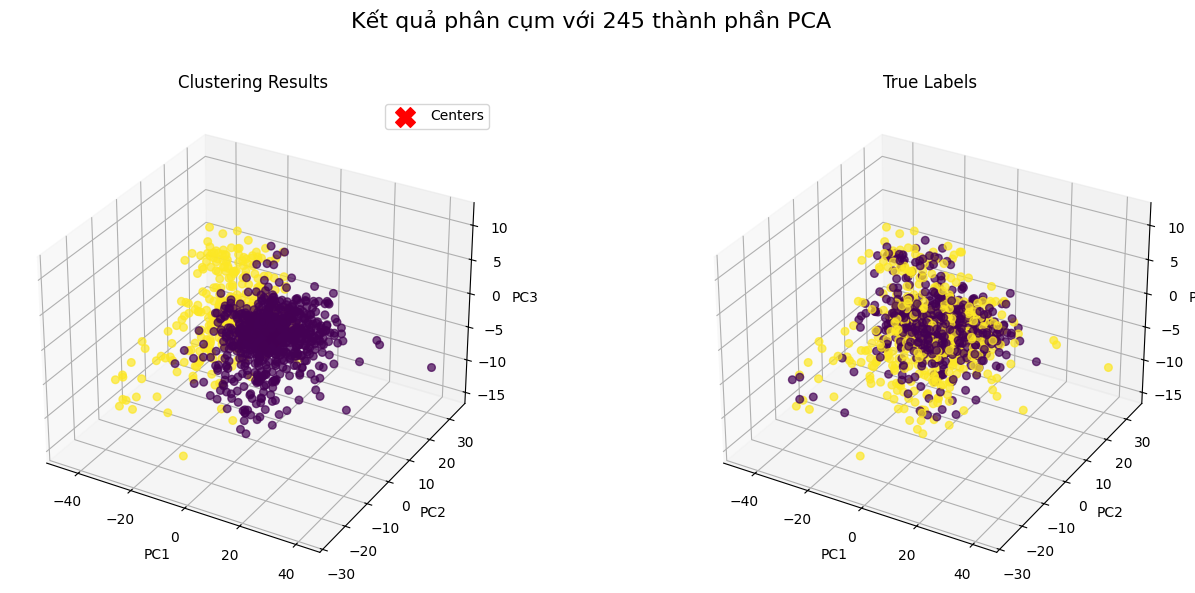


Kết quả cuối cùng:
Số đặc trưng đã chọn: 934
Số thành phần PCA: 245
Silhouette: 0.1718
Davies_bouldin: 1.9989
Accuracy: 0.5329
Precision: 0.4905
Recall: 0.3348
F1: 0.3979
Confusion Matrix:
[[380 161]
 [308 155]]


In [158]:
final_labels, final_metrics, num_pca_components, X_pca_data, selected_feature_mask = clustering_pipeline(
    X, 
    y=y_numeric,
    n_clusters=2, 
    variance_threshold_quantile=0.1, 
    correlation_threshold=0.85, 
    pca_variance_explained_threshold=0.9, 
    kmeans_n_init=20, 
    kmeans_random_state=123,
    algo="kmeans"
)